In [6]:
import os
import random

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [7]:
class AugmentConfig(object):
    def __init__(self, flip=True, rotate=True, rotate_value=0.2, crop=True, brightness=False, brightness_value=0.05):
        self.flip = flip
        self.rotate = rotate
        self.rotate_value = rotate_value
        self.crop = crop
        self.brightness = brightness
        self.brightness_value = brightness_value

class Augment(tf.keras.layers.Layer):
  def __init__(self, seed=42, augment_config=AugmentConfig()):
    super().__init__()
    # both use the same seed, so they'll make the same random changes.
    data_augmentation = tf.keras.Sequential()
    if augment_config.flip:
        data_augmentation.add(tf.keras.layers.RandomFlip("horizontal_and_vertical", seed=seed))
    if augment_config.rotate:
        data_augmentation.add(tf.keras.layers.RandomRotation(augment_config.rotate_value, seed=seed))
    if augment_config.crop:
        data_augmentation.add(tf.keras.layers.RandomCrop(height=256, width=256, seed=seed))
    if augment_config.brightness:
        data_augmentation.add(tf.keras.layers.RandomBrightness(factor=augment_config.brightness_value, seed=seed))

    self.augment_inputs = data_augmentation
    self.augment_labels = tf.keras.models.clone_model(data_augmentation)

  def call(self, inputs, labels):
    print("augment_inputs")
    for layer in self.augment_inputs.layers:
        print(layer.variables)
    print("augment_labels")
    for layer in self.augment_labels.layers:
        print(layer.variables)
    inputs = self.augment_inputs(inputs)
    labels = self.augment_labels(labels)
    return inputs, labels

def get_files(folder):
    filenames = []
    for root, dirs, files in os.walk(folder):
        for file in files:
            if file.endswith(".png") and "imgs" in root:
                filenames.append(os.path.join(root, file))
    return filenames

def normalize(image):
    image = tf.cast(image, tf.float32) / 255.0
    return image


def load_image(image_path):
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=1)
    image = tf.image.resize(image, IMSIZE)
    return image


def load_mask(mask_path):
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMSIZE)
    return mask


def load_image_pair(image_path):
    image = load_image(image_path[0])
    mask = load_mask(image_path[1])
    image = normalize(image)
    mask = normalize(mask)
    return image, mask

def create_dataset(paths, batch_size=32, buffer_size=100, augment_config=AugmentConfig()):
    dataset = tf.data.Dataset.from_tensor_slices(paths)
    dataset = dataset.map(load_image_pair, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    batches = (
        dataset
        .cache()
        .shuffle(buffer_size)
        .batch(batch_size)
        .prefetch(tf.data.experimental.AUTOTUNE)
        .map(Augment(augment_config=augment_config))
    )
    return batches

In [8]:
# Create the dataset
BUFFER_SIZE = 100
BATCH_SIZE = 32
IMSIZE = (256, 256)

files = get_files("data/")
train_paths = [(path, path.replace("imgs", "targets")) for path in files if "train" in path]
test_paths = [(path, path.replace("imgs", "targets")) for path in files if "test" in path]
val_paths = [(path, path.replace("imgs", "targets")) for path in files if "valid" in path]

print("Number of training samples: ", len(train_paths),
      "\nNumber of validation samples: ", len(val_paths),
      "\nNumber of test samples: ", len(test_paths))

train_batches = create_dataset(train_paths, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
test_batches = create_dataset(test_paths, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)
val_batches = create_dataset(val_paths, batch_size=BATCH_SIZE, buffer_size=BUFFER_SIZE)

Number of training samples:  320 
Number of validation samples:  91 
Number of test samples:  47
augment_inputs
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_12/seed_generator_state>]
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_13/seed_generator_state>]
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_14/seed_generator_state>]
augment_labels
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_15/seed_generator_state>]
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_16/seed_generator_state>]
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_17/seed_generator_state>]
augment_inputs
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_12/seed_generator_state>]
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_13/seed_generator_state>]
[<KerasVariable shape=(2,), dtype=uint32, path=seed_generator_14/seed_generator_state>]
augment_labels
[<KerasVariable shape=(2,), dtype=uint32, path=seed

In [11]:
# set up the model architecture (simple baseline model)
model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=[*IMSIZE, 1]),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(np.prod(IMSIZE), activation='sigmoid'),
    tf.keras.layers.Reshape((*IMSIZE, 1))
])

# compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.BinaryCrossentropy(),
    metrics=['accuracy'])

model.summary()

EPOCHS = 100
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=val_batches,
                    verbose=2)

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ flatten_2 (Flatten)             │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1024)           │    67,109,888 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 65536)          │    67,174,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_2 (Reshape)             │ (None, 256, 256, 1)    │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,284,288 (512.25 MB)

 Trainable params: 134,284,288 (512.25 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100


10/10 - 2s - 177ms/step - accuracy: 0.8529 - loss: 0.3922 - val_accuracy: 0.9175 - val_loss: 0.2758
Epoch 2/100
10/10 - 1s - 69ms/step - accuracy: 0.9148 - loss: 0.2813 - val_accuracy: 0.9180 - val_loss: 0.2600
Epoch 3/100
10/10 - 1s - 70ms/step - accuracy: 0.9145 - loss: 0.2780 - val_accuracy: 0.9172 - val_loss: 0.2585
Epoch 4/100
10/10 - 1s - 66ms/step - accuracy: 0.9150 - loss: 0.2644 - val_accuracy: 0.9160 - val_loss: 0.2458
Epoch 5/100
10/10 - 1s - 68ms/step - accuracy: 0.9142 - loss: 0.2491 - val_accuracy: 0.9154 - val_loss: 0.2417
Epoch 6/100
10/10 - 1s - 67ms/step - accuracy: 0.9138 - loss: 0.2314 - val_accuracy: 0.9164 - val_loss: 0.2159
Epoch 7/100
10/10 - 1s - 66ms/step - accuracy: 0.9156 - loss: 0.2126 - val_accuracy: 0.9173 - val_loss: 0.1986
Epoch 8/100
10/10 - 1s - 71ms/step - accuracy: 0.9163 - loss: 0.2037 - val_accuracy: 0.9160 - val_loss: 0.1991
Epoch 9/100
10/10 - 1s - 68ms/step - accuracy: 0.9154 - loss: 0.1978 - val_accuracy: 0.9165 - val_loss: 0.1930
Epoch 10/100

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step


2024-06-04 20:28:49.156930: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


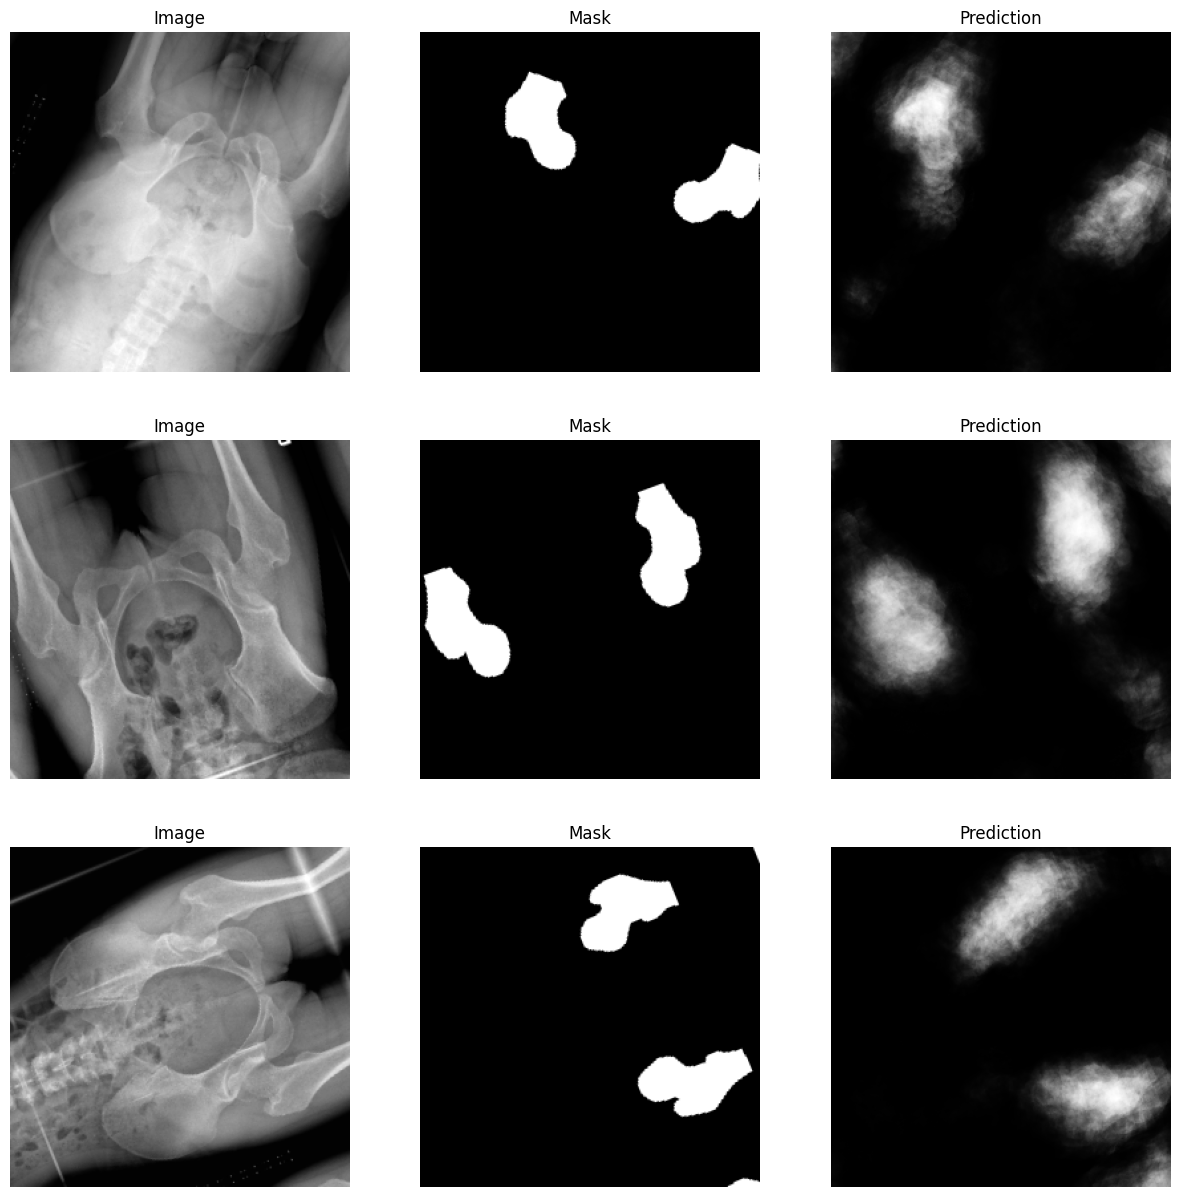

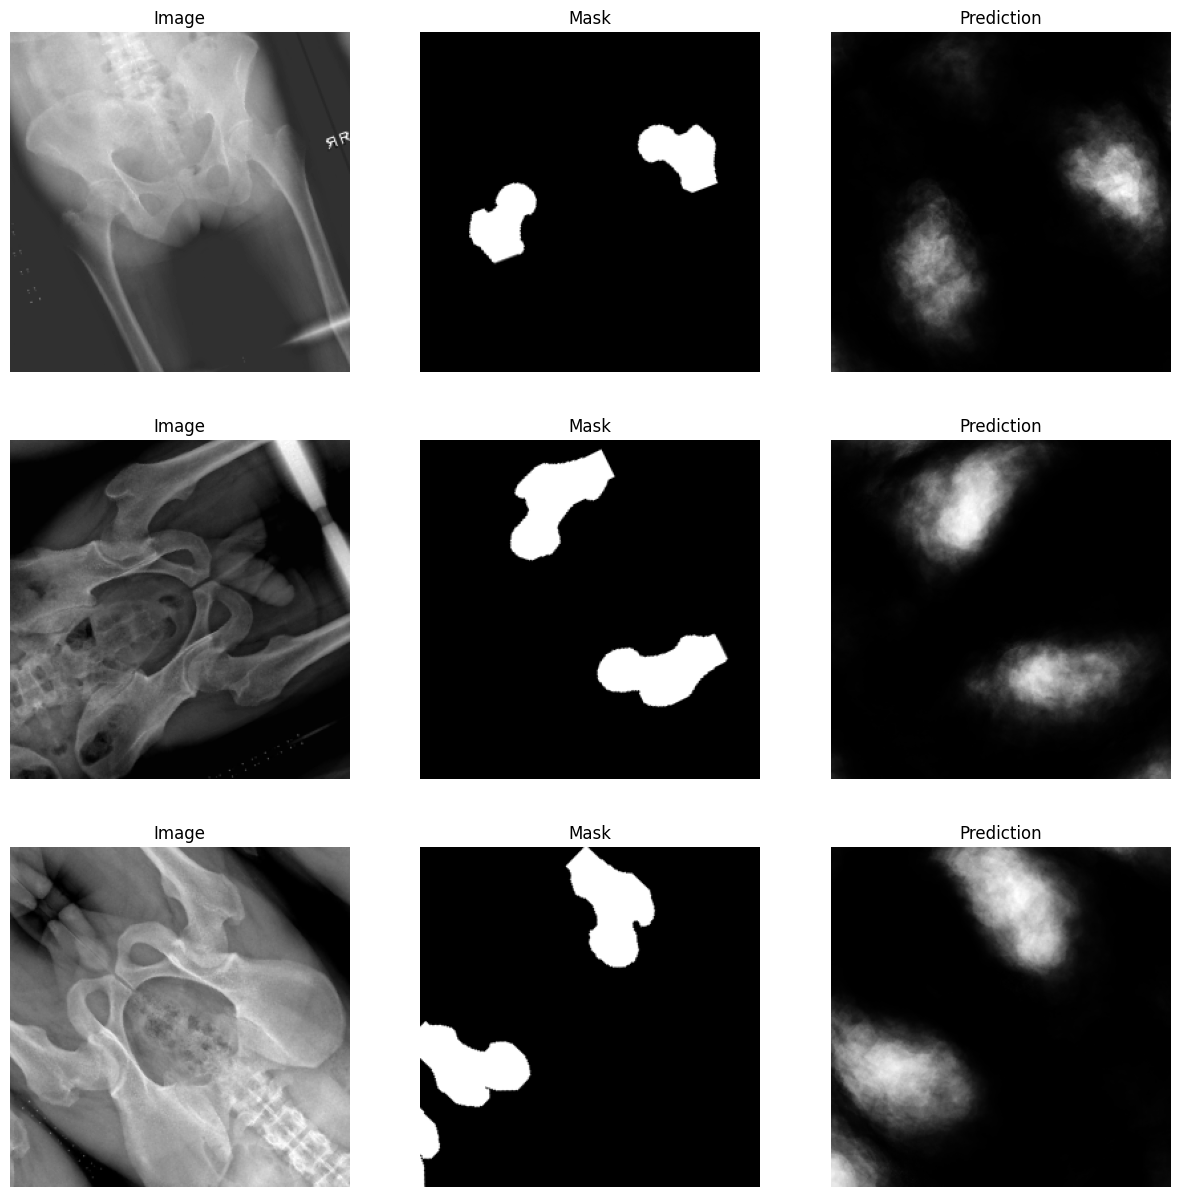

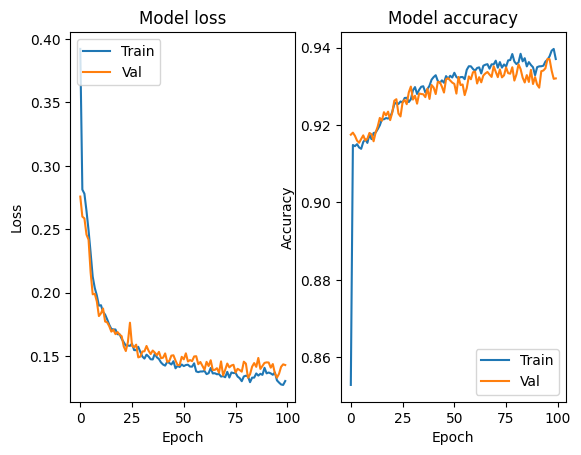

In [12]:
# evaluate the model
for images, masks in test_batches.take(2):
    predictions = model.predict(images)
    fig, axs = plt.subplots(3, 3, figsize=(15, 15))
    for ii, (img, msk, prediction) in enumerate(zip(images, masks, predictions)):
        axs[ii, 0].imshow(img, cmap='gray')
        axs[ii, 1].imshow(msk, cmap='gray')
        axs[ii, 2].imshow(prediction, cmap='gray')
        axs[ii, 0].axis("off")
        axs[ii, 1].axis("off")
        axs[ii, 2].axis("off")
        axs[ii, 0].set_title("Image")
        axs[ii, 1].set_title("Mask")
        axs[ii, 2].set_title("Prediction")
        if ii == 2:
            break

fig, axs = plt.subplots(1, 2)
axs[0].plot(history.history['loss'])
axs[0].plot(history.history['val_loss'])
axs[1].plot(history.history['accuracy'])
axs[1].plot(history.history['val_accuracy'])
axs[0].set_title('Model loss')
axs[0].set_ylabel('Loss')
axs[0].set_xlabel('Epoch')
axs[0].legend(['Train', 'Val'], loc='upper left')
axs[1].set_title('Model accuracy')
axs[1].set_ylabel('Accuracy')
axs[1].set_xlabel('Epoch')
axs[1].legend(['Train', 'Val'], loc='lower right')
plt.show()

# Without Augmentation
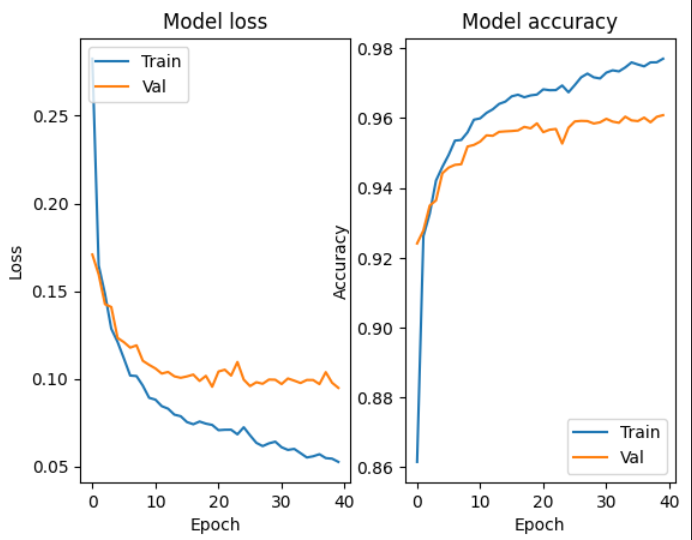

# With Augmentation
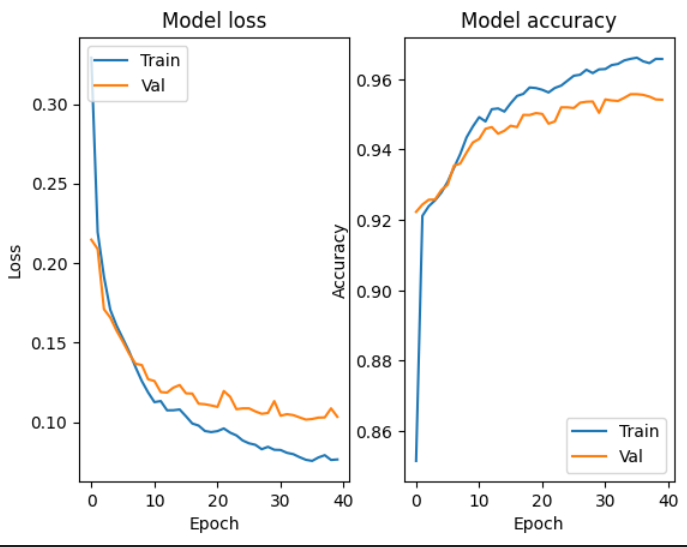

# With Augmentation (Flip and Rotate)
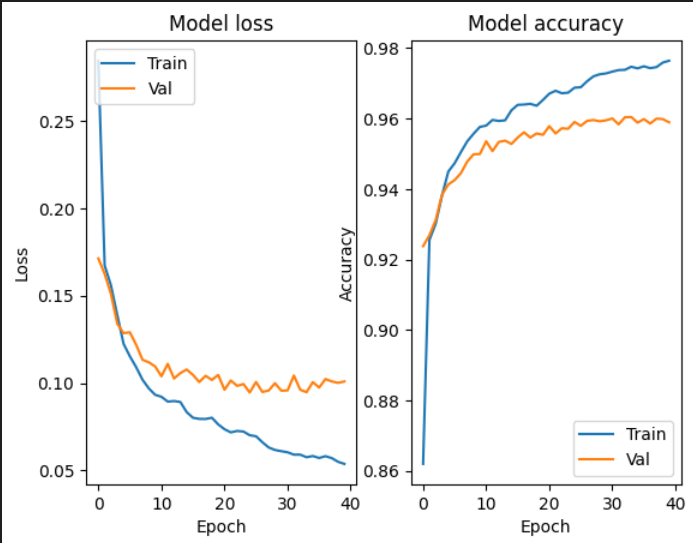

# With Augmentation (Flip, Rotate, Crop)
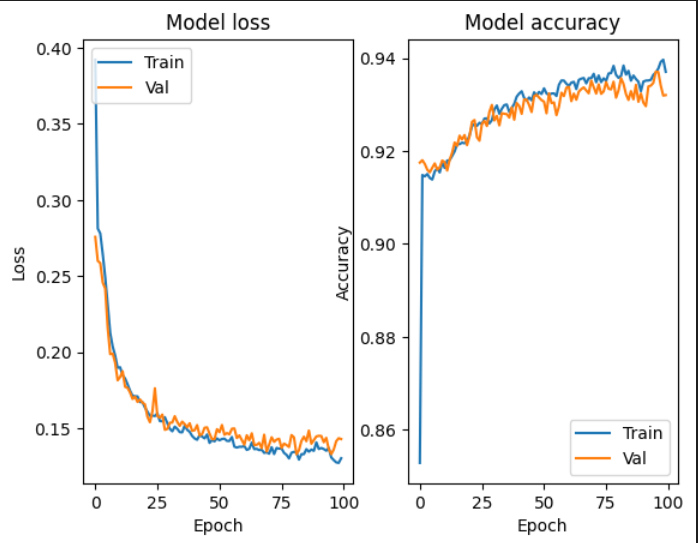